In [11]:
def step_minimize(f, df, x0, step_size=0.01, tol=1e-10):
    x = x0
    f_val = f(x)
    
    while step_size > tol:
        direction = -1 if df(x) > 0 else 1  # Go opposite to gradient
        new_x = x + direction * step_size
        new_f_val = f(new_x)

        if new_f_val < f_val:
            x, f_val = new_x, new_f_val
        else:
            step_size /= 2  # Reduce step size

    return x, f_val

In [12]:
x0 = 20
for r in [10, 100, 1000, 10000]:
    f = lambda x: 100/x + r * (max(0, x - 5))**2
    df = lambda x: -100/x**2 + (0 if x <= 5 else 2 * r * (x - 5))
    x0, val = step_minimize(f, df, x0)
    print(f"r={r}, x={x0:.6f}, f(x)={val:.6f}")


r=10, x=5.185917, f(x)=19.628644
r=100, x=5.019842, f(x)=19.960316
r=1000, x=5.001998, f(x)=19.996003
r=10000, x=5.000200, f(x)=19.999600


In [13]:
def penalty_minimize(f_base, g, dg, x0, r_values):
    x = x0
    for r in r_values:
        f = lambda x: f_base(x) + r * (max(0, g(x)))**2
        df = lambda x: f_base.deriv(x) + (0 if g(x) <= 0 else 2 * r * g(x) * dg(x))
        x, val = step_minimize(f, df, x)
    return x, val


In [14]:
f_base = lambda x: 0.8*x**2 - 2*x
f_base.deriv = lambda x: 1.6*x - 2
g = lambda x: x - 4
dg = lambda x: 1

penalty_minimize(f_base, g, dg, x0=10, r_values=[10, 100, 1000, 10000])


(1.2499999904634267, -1.25)

In [15]:
f = lambda x: (x - 8)**2 + 1000 * (max(0, 10 - x))**2
df = lambda x: 2*(x - 8) - (0 if x >= 10 else 2 * 1000 * (10 - x))

x, val = step_minimize(f, df, x0=5)
print(f"x = {x}, f(x) = {val}")


x = 9.998001997768775, f(x) = 3.9960039960039957


In [ ]:
import numpy as np
from scipy.optimize import minimize

# Parameters
N = 100  # number of segments
L = 1.0  # total length
ds = L / N  # segment length
EIb = 1.0  # flexural rigidity
Ty = 1.0   # vertical force
Tx = 1.0   # horizontal force
y_limit = 0.5  # constraint on y

# Initial guess: straight line
y0 = np.linspace(0, 0, N+1)  # initial y values (can be zeros)

# Define the energy functional (only y as variable)
def energy(y):
    theta = (y[1:] - y[:-1]) / ds
    bending = np.sum((theta[1:] - theta[:-1])**2)
    potential = -Ty * np.sum(np.sin(theta)) + Tx * np.sum(1 - np.cos(theta))

    return EIb * bending + potential

# Constraint: y values should be within [-y_limit, y_limit]
bounds = [(-y_limit, y_limit) for _ in range(N+1)]

# Minimize
result = minimize(energy, y0, bounds=bounds)

# Extract results
y_opt = result.x
theta_opt = (y_opt[1:] - y_opt[:-1]) / ds


<h1>Ukrivljen nosilec<h1>

In [17]:
import numpy as np

# 1. Define geometry and beam parameters
Ri = 0.99   # inner channel radius
Ro = 1.01   # outer channel radius
L = np.pi/2 # beam length
N = 45      # number of segments
l = L/N     # segment length

# External tip force (e.g., pointing radially outward)
Tx, Ty = -500000, -5000.0

# 2. Clamped base: position and orientation
base_pos = np.array([0.0, -Ri])  # start at inner wall at bottom
base_angle = 0.0                 # initial orientation (tangent)
# Compute first node (segment 1) with fixed orientation
first_pos = base_pos + np.array([l*np.cos(base_angle), l*np.sin(base_angle)])
# Initial cost: work done by T for this segment (no bending at base)
initial_cost = -(Tx*(first_pos[0]-base_pos[0]) + Ty*(first_pos[1]-base_pos[1]))
states = [{
    'angles': [base_angle],  # orientation history
    'pos': first_pos,        # current node position
    'cost': initial_cost,    # cumulative energy (negative work is energy decrease)
    'angle': base_angle
}]

# 3. Viterbi DP over subsequent segments
delta = 0.05  # angle increment (rad)
angle_steps = np.array([-delta, 0.0, +delta])
K = 2000     # keep top K states at each step

for i in range(2, N+1):
    new_states = []
    for st in states:
        curr_angle = st['angle']
        curr_pos = st['pos']
        curr_cost = st['cost']
        # Try each allowed angle change
        for dθ in angle_steps:
            θ_new = curr_angle + dθ
            # Move one segment
            new_pos = curr_pos + np.array([l*np.cos(θ_new), l*np.sin(θ_new)])
            r = np.hypot(new_pos[0], new_pos[1])
            # Enforce wall constraints
            if Ri <= r <= Ro:
                # Bending energy (1/2 * (Δθ)^2) and work of T
                bend = 0.5 * (dθ**2)
                dx = new_pos[0] - curr_pos[0]
                dy = new_pos[1] - curr_pos[1]
                work = -(Tx*dx + Ty*dy)
                cost_new = curr_cost + bend + work
                new_states.append({
                    'angles': st['angles'] + [θ_new],
                    'pos': new_pos,
                    'cost': cost_new,
                    'angle': θ_new
                })
    # If too many states, prune to best K by cost
    if len(new_states) > K:
        new_states = sorted(new_states, key=lambda s: s['cost'])[:K]
    states = new_states

# 4. Extract best (lowest-cost) final state
best = min(states, key=lambda s: s['cost'])
beam_angles = best['angles']
print("Minimum energy =", best['cost'])


Minimum energy = 500072.9800457826


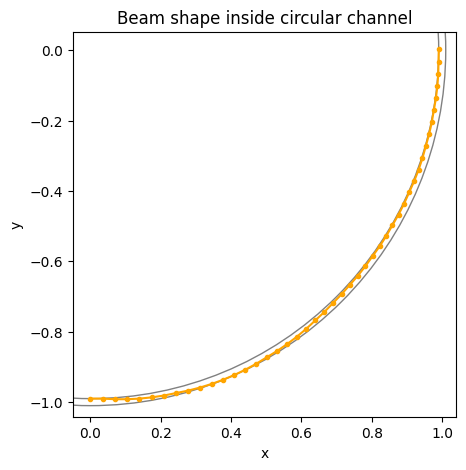

In [18]:
import matplotlib.pyplot as plt

# Reconstruct positions from beam_angles
pos = base_pos.copy()
nodes = [pos.copy()]
for θ in beam_angles:
    pos = pos + np.array([l*np.cos(θ), l*np.sin(θ)])
    nodes.append(pos.copy())
nodes = np.array(nodes)

# Plot channel and beam
fig, ax = plt.subplots(figsize=(5,5))
circle_inner = plt.Circle((0,0), Ri, color='gray', fill=False)
circle_outer = plt.Circle((0,0), Ro, color='gray', fill=False)
ax.add_artist(circle_inner)
ax.add_artist(circle_outer)
ax.plot(nodes[:,0], nodes[:,1], '-o', color='orange', markersize=3)
ax.set_aspect('equal', 'box')
plt.title('Beam shape inside circular channel')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


Minimum energy = -20.556566463692498


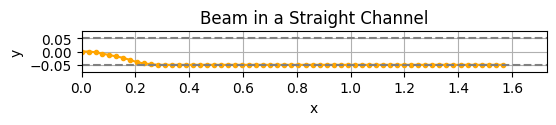

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
Rlimit = 0.05  # wall half-spacing
L = np.pi / 2  # beam length
N = 60         # number of segments
l = L / N      # length per segment
Tx, Ty = 10.0, -100.0  # applied load
delta = 0.1    # angle step
angle_steps = np.array([-delta, 0.0, +delta])
K = 200        # number of top paths to retain

# Initial state
base_pos = np.array([0.0, 0.0])  # left end clamped at origin
base_angle = 0.0
first_pos = base_pos + np.array([l * np.cos(base_angle), l * np.sin(base_angle)])
initial_cost = -(Tx * (first_pos[0] - base_pos[0]) + Ty * (first_pos[1] - base_pos[1]))

states = [{
    'angles': [base_angle],
    'pos': first_pos,
    'cost': initial_cost,
    'angle': base_angle
}]

# Viterbi DP
for i in range(2, N + 1):
    new_states = []
    for st in states:
        curr_angle = st['angle']
        curr_pos = st['pos']
        curr_cost = st['cost']
        for dtheta in angle_steps:
            theta_new = curr_angle + dtheta
            new_pos = curr_pos + np.array([l * np.cos(theta_new), l * np.sin(theta_new)])
            # Channel constraint
            if abs(new_pos[1]) <= Rlimit:
                bend = 0.5 * dtheta ** 2
                dx = new_pos[0] - curr_pos[0]
                dy = new_pos[1] - curr_pos[1]
                work = -(Tx * dx + Ty * dy)
                cost_new = curr_cost + bend + work
                new_states.append({
                    'angles': st['angles'] + [theta_new],
                    'pos': new_pos,
                    'cost': cost_new,
                    'angle': theta_new
                })
    # Prune
    if len(new_states) > K:
        new_states = sorted(new_states, key=lambda s: s['cost'])[:K]
    states = new_states

# Get best result
best = min(states, key=lambda s: s['cost'])
beam_angles = best['angles']
print("Minimum energy =", best['cost'])

# Reconstruct beam
pos = base_pos.copy()
nodes = [pos.copy()]
for θ in beam_angles:
    pos = pos + np.array([l * np.cos(θ), l * np.sin(θ)])
    nodes.append(pos.copy())
nodes = np.array(nodes)

# Plot
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(nodes[:, 0], nodes[:, 1], '-o', color='orange', markersize=3)
ax.axhline(Rlimit, color='gray', linestyle='--')
ax.axhline(-Rlimit, color='gray', linestyle='--')
ax.set_aspect('equal')
ax.set_xlim([0, L * 1.1])
ax.set_ylim([-Rlimit * 1.5, Rlimit * 1.5])
plt.title('Beam in a Straight Channel')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()


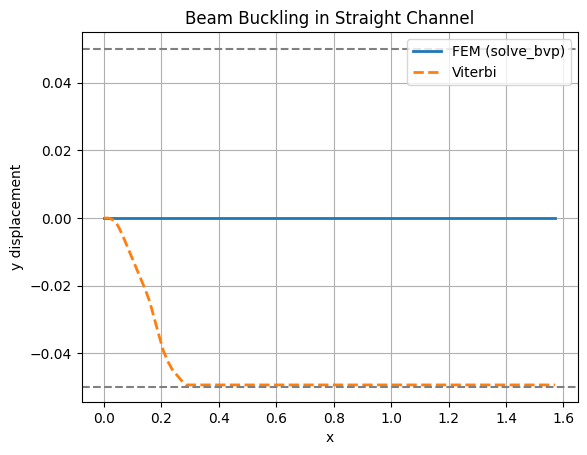

In [20]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt

# Beam parameters
L = np.pi / 2
EI = 1.0
T = -1.0  # axial compressive load
Rlimit = 0.05

# Beam differential equation as first-order system
def beam_ode(x, y):
    # y[0] = u (displacement)
    # y[1] = u'
    # y[2] = u''
    # y[3] = u'''
    dydx = np.zeros_like(y)
    dydx[0] = y[1]
    dydx[1] = y[2]
    dydx[2] = y[3]
    dydx[3] = -T / EI * y[2]  # geometric stiffness term
    return dydx

# Boundary conditions: clamped at x=0, free at x=L
def bc(ya, yb):
    return np.array([ya[0], ya[1], yb[2], yb[3]])

# Initial guess
x = np.linspace(0, L, 100)
y_guess = np.zeros((4, x.size))
sol = solve_bvp(beam_ode, bc, x, y_guess)

# Solution
u = sol.sol(x)[0]

# Viterbi comparison (assume `nodes` is computed from previous Viterbi run)
# Note: we'll resample Viterbi nodes to match x for fair comparison

# If Viterbi beam has 'nodes'
from scipy.interpolate import interp1d
x_vit = nodes[:, 0]
y_vit = nodes[:, 1]
f_interp = interp1d(x_vit, y_vit, kind='linear', fill_value='extrapolate')
y_vit_interp = f_interp(x)

# Plot comparison
plt.plot(x, u, label='FEM (solve_bvp)', lw=2)
plt.plot(x, y_vit_interp, '--', label='Viterbi', lw=2)
plt.axhline(Rlimit, color='gray', linestyle='--')
plt.axhline(-Rlimit, color='gray', linestyle='--')
plt.xlabel('x')
plt.ylabel('y displacement')
plt.title('Beam Buckling in Straight Channel')
plt.legend()
plt.grid(True)
plt.show()


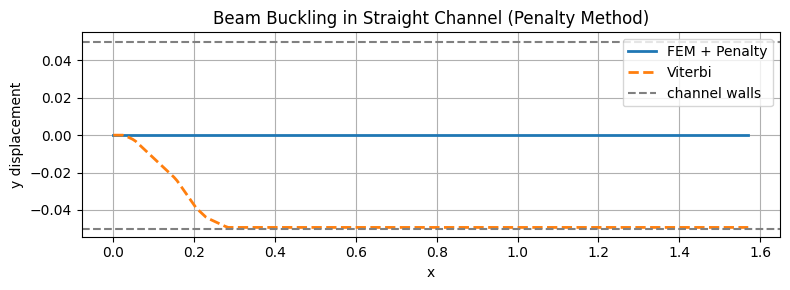

In [21]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt

# Parameters
L = np.pi / 2
EI = 1.0
T = -1.0       # compressive axial load
Rlimit = 0.05  # channel constraint
kp = 1e5       # penalty stiffness

# Beam ODE system with penalty force
def beam_ode_penalty(x, y):
    dydx = np.zeros_like(y)
    dydx[0] = y[1]         # y
    dydx[1] = y[2]         # y'
    dydx[2] = y[3]         # y''
    dydx[3] = -(T / EI) * y[2] + penalty_force(y[0]) / EI
    return dydx

# Penalty force function (per x)
def penalty_force(y_val):
    f = np.zeros_like(y_val)
    over = y_val > Rlimit
    under = y_val < -Rlimit
    f[over] = kp * (y_val[over] - Rlimit)
    f[under] = kp * (y_val[under] + Rlimit)
    return f

# Boundary conditions: clamped at x=0, free at x=L
def bc(ya, yb):
    return np.array([ya[0], ya[1], yb[2], yb[3]])

# Initial guess
x = np.linspace(0, L, 200)
y_guess = np.zeros((4, x.size))
sol = solve_bvp(beam_ode_penalty, bc, x, y_guess, max_nodes=10000)

# Solution
y_fem = sol.sol(x)[0]

# Optional: Viterbi comparison (assume you already computed `nodes`)
try:
    from scipy.interpolate import interp1d
    x_vit = nodes[:, 0]
    y_vit = nodes[:, 1]
    f_interp = interp1d(x_vit, y_vit, kind='linear', fill_value='extrapolate')
    y_vit_interp = f_interp(x)
    has_viterbi = True
except NameError:
    has_viterbi = False

# Plot
plt.figure(figsize=(8, 3))
plt.plot(x, y_fem, label='FEM + Penalty', lw=2)
if has_viterbi:
    plt.plot(x, y_vit_interp, '--', label='Viterbi', lw=2)
plt.axhline(Rlimit, color='gray', linestyle='--', label='channel walls')
plt.axhline(-Rlimit, color='gray', linestyle='--')
plt.title('Beam Buckling in Straight Channel (Penalty Method)')
plt.xlabel('x')
plt.ylabel('y displacement')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


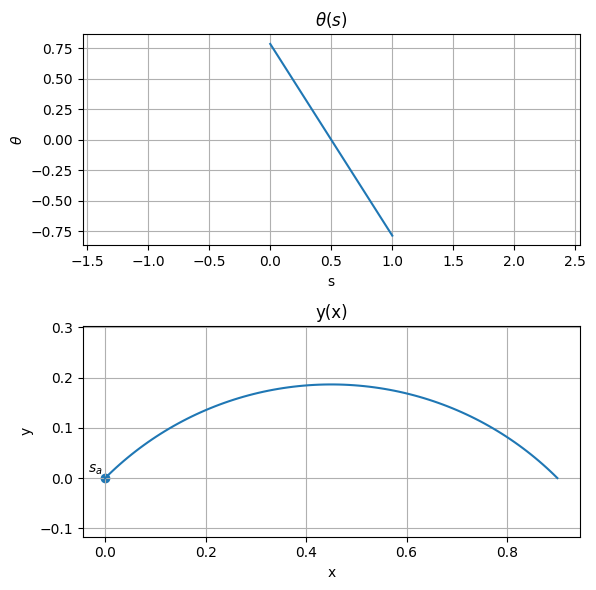

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

n = 100
s = np.linspace(0, 1, n)

theta = np.linspace(np.pi/4, -np.pi/4, n)

def xy_coordinates(s, theta, x_s_a, y_s_a):
    """
    Na podlagi s, theta(s), x(s_a) in y(s_a) izračuna koordinate x(s) in y(s) ter nariše grafa theta(s) in y(x).
    """
    dx_ds = np.cos(theta)
    x = cumulative_trapezoid(dx_ds, s, initial=x_s_a)

    dy_ds = np.sin(theta)
    y = cumulative_trapezoid(dy_ds, s, initial=y_s_a)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,6))

    ax1.plot(s, theta)
    ax1.set_title("$\\theta(s)$")
    ax1.set_ylabel("$\\theta$")
    ax1.set_xlabel("s")
    ax1.axis('equal')
    ax1.grid()

    ax2.plot(x, y)
    ax2.set_title("y(x)")
    ax2.set_ylabel("y")
    ax2.set_xlabel("x")
    ax2.axis('equal')
    ax2.grid()
    ax2.scatter(x_s_a, y_s_a)
    ax2.annotate("$s_a$", (x_s_a, y_s_a), xytext=(x_s_a-0.035, y_s_a+0.01))

    plt.tight_layout()
    plt.show()

xy_coordinates(s, theta, 0, 0)

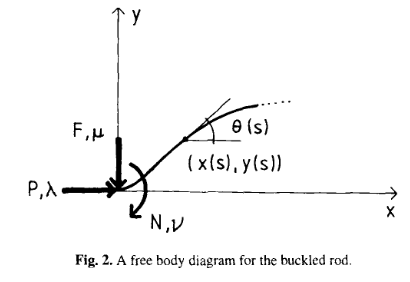

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.integrate import solve_ivp

n = 1000 # št. vozlišč
L = 10 # dolžina nosilca
s = np.linspace(0, L, n) # kotna dolžina
E = 1 # Modul elastičnosti
I = 1 # drugi moment prereza
P = 0 # sila x
F = 0 # sila y

lamb = (L**2 * P) / (E * I) # brezdimenzijska sila x
mu = (L**2 * F) / (E * I) # brezdimenzijska sila y

# undetermined initial condition:
# a) Togo vpet nosilec:
N = 0 # moment
nu = (L * N) / (E * I) # brezdimenzijski moment v podpori
# b) Členkasto vpet nosilec:
theta0 = 0 # kot nosilca v podpori

d2theta_ds2 = - lamb*np.sin(theta) - mu*np.cos(theta)

dtheta_ds = cumulative_trapezoid(d2theta_ds2, s, initial=nu)

theta = cumulative_trapezoid(dtheta_ds, s, initial=theta0)

xy_coordinates(s, theta, 0, 0)

ValueError: If given, length of x along axis must be the same as y.

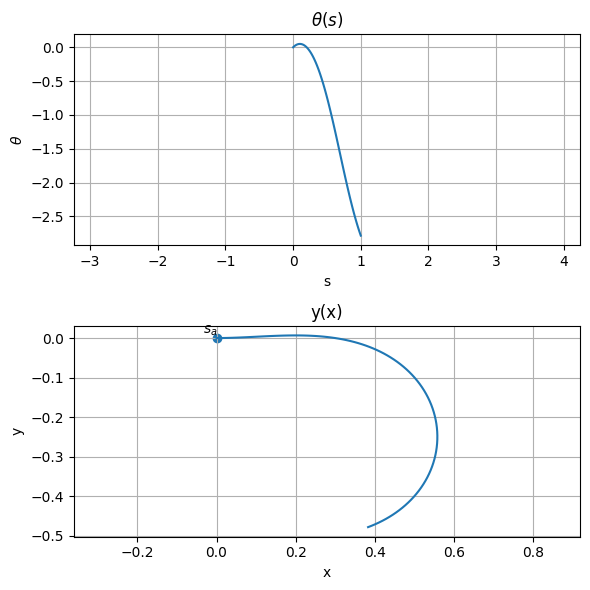

In [ ]:
lamb = 0
mu = 10.0

def fun(s, theta):
    return [theta[1], -lamb * np.sin(theta[0]) - mu * np.cos(theta[0])]

L = 1
N = 101
s = [0, L]
s_eval = np.linspace(0, L, N)
theta0 = [0, 1]

theta = solve_ivp(fun, s, theta0, t_eval=s_eval).y[0]

xy_coordinates(s_eval, theta, 0, 0)

vars: [ 0.1  1.   0.  10. ], residuals: [np.float64(-2.7920298287635865), np.float64(-3.137898977851754), np.float64(-0.3862101022148247), np.float64(-0.6245869513557)]
vars: [ 0.1  1.   0.  10. ], residuals: [np.float64(-2.7920298287635865), np.float64(-3.137898977851754), np.float64(-0.3862101022148247), np.float64(-0.6245869513557)]
vars: [ 0.1  1.   0.  10. ], residuals: [np.float64(-2.7920298287635865), np.float64(-3.137898977851754), np.float64(-0.3862101022148247), np.float64(-0.6245869513557)]
vars: [ 0.1  1.   0.  10. ], residuals: [np.float64(-2.7920298287619447), np.float64(-3.137898982581712), np.float64(-0.38621010174182874), np.float64(-0.6245869505396009)]
vars: [ 0.1         1.00000001  0.         10.        ], residuals: [np.float64(-2.7920298240626256), np.float64(-3.137898996675732), np.float64(-0.38621009884231045), np.float64(-0.6245869498730852)]
vars: [1.00000000e-01 1.00000000e+00 1.49011612e-08 1.00000000e+01], residuals: [np.float64(-2.7920298272751105), np.fl

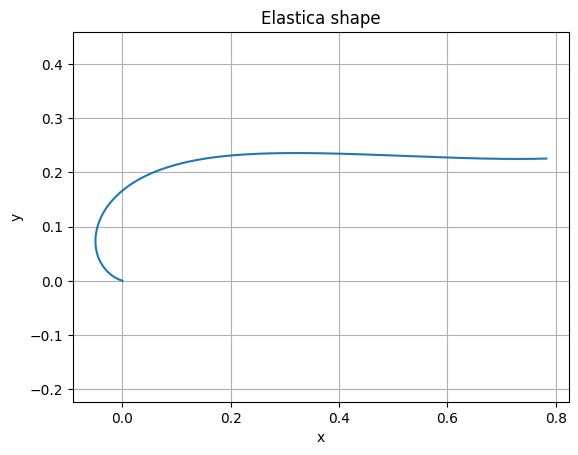

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root
import matplotlib.pyplot as plt

# Define the elastica ODE system
def elastica_ode(s, y, lamb, mu):
    theta, dtheta, x, y_pos = y
    d2theta = -lamb * np.sin(theta) - mu * np.cos(theta)
    dx = np.cos(theta)
    dy = np.sin(theta)
    return [dtheta, d2theta, dx, dy]

# Integrate one segment from s=0 to s=L
def integrate_elastica(L, y0, lamb, mu):
    sol = solve_ivp(
        lambda s, y: elastica_ode(s, y, lamb, mu),
        [0, L],
        y0,
        t_eval=[L],
        rtol=1e-8,
        atol=1e-8
    )
    return sol.y[:, -1]  # return theta, dtheta, x, y at s=L

# Define residuals for boundary conditions
def residuals(vars, L, target):
    theta0, dtheta0, lamb, mu = vars
    y0 = [theta0, dtheta0, 0.0, 0.0]
    result = integrate_elastica(L, y0, lamb, mu)
    thetaL, dthetaL, xL, yL = result

    res = [
        thetaL - target[0],
        dthetaL - target[1],
        xL - target[2],
        yL - target[3]
    ]
    print(f"vars: {vars}, residuals: {res}")
    return res


# Example usage
L = 1.0
initial_guess = [0.1, 1.0, 0.0, 10.0]  # [theta0, dtheta0, lamb, mu]
target = [0.0, 0.0, 0.8, 0.2]  # desired [thetaL, dthetaL, xL, yL]

sol = root(residuals, initial_guess, args=(L, target), method='hybr')


theta0, dtheta0, lamb, mu = sol.x
y0 = [theta0, dtheta0, 0.0, 0.0]
s_vals = np.linspace(0, L, 300)
full_sol = solve_ivp(
    lambda s, y: elastica_ode(s, y, lamb, mu),
    [0, L], y0, t_eval=s_vals
)

x_vals = full_sol.y[2]
y_vals = full_sol.y[3]

plt.plot(x_vals, y_vals)
plt.title("Elastica shape")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.grid(True)
plt.show()



In [ ]:
import numpy as np

def viterbi(transitions, emissions, observations):
    """
    Implements the Viterbi algorithm.

    Args:
        transitions (dict): A dictionary representing the transition probabilities
                           between hidden states. Keys are current states, and values
                           are dictionaries mapping next states to probabilities.
        emissions (dict): A dictionary representing the emission probabilities.
                         Keys are hidden states, and values are dictionaries
                         mapping observations to probabilities.
        observations (list): A list of observed values.

    Returns:
        list: The most likely sequence of hidden states.
    """
    num_states = len(transitions)
    state_names = list(transitions.keys())
    num_observations = len(observations)

    # Initialize Viterbi path probabilities and backpointers
    viterbi_probabilities = np.zeros((num_states, num_observations))
    backpointers = np.zeros((num_states, num_observations), dtype=int)

    # Initialization step (t=0) - assuming a starting state 's0' with equal probability for all initial states
    initial_probability = 1.0 / num_states
    for i, state in enumerate(state_names):
        if observations[0] in emissions[state]:
            viterbi_probabilities[i, 0] = initial_probability * emissions[state][observations[0]]
        else:
            viterbi_probabilities[i, 0] = 0.0
        backpointers[i, 0] = -1  # No previous state for the initial step

    # Recursion step (t > 0)
    for t in range(1, num_observations):
        for i, current_state in enumerate(state_names):
            max_probability = 0.0
            best_previous_state_index = -1
            for j, previous_state in enumerate(state_names):
                if current_state in transitions[previous_state] and observations[t] in emissions[current_state]:
                    probability = viterbi_probabilities[j, t - 1] * transitions[previous_state][current_state] * emissions[current_state][observations[t]]
                    if probability > max_probability:
                        max_probability = probability
                        best_previous_state_index = j

            viterbi_probabilities[i, t] = max_probability
            backpointers[i, t] = best_previous_state_index

    # Termination step
    best_path_probability = np.max(viterbi_probabilities[:, num_observations - 1])
    end_state_index = np.argmax(viterbi_probabilities[:, num_observations - 1])

    # Backtrack to find the most likely sequence of hidden states
    best_path = [state_names[end_state_index]]
    for t in range(num_observations - 1, 0, -1):
        end_state_index = backpointers[end_state_index, t]
        best_path.insert(0, state_names[end_state_index])

    return best_path

# Example usage based on the provided text
transitions_example = {
    's0': {'0': 1.0, 'p/6': 0.0, 'p/3': 0.0}, # Assuming start from 's0' to the first stage
    '0': {'0': 1.0, 'p/6': 1.0, 'p/3': 1.0},
    'p/6': {'0': 1.0, 'p/6': 1.0, 'p/3': 1.0},
    'p/3': {'0': 1.0, 'p/6': 1.0, 'p/3': 1.0}
}

emissions_example = {
    '0': {'a': 1.0},
    'p/6': {'b': 1.0},
    'p/3': {'c': 1.0}
}

observations_example = ['a', 'b', 'c'] # Example observations, not directly from the text's numerical example

# Re-interpreting the provided numerical example to fit the algorithm structure
# The text focuses on the metric (cost) minimization, while the standard Viterbi
# maximizes probability. To adapt, we can think of the negative logarithm of
# probabilities as the metric and perform minimization. However, without the
# actual probabilities, we will implement the standard Viterbi.

# Let's create a simplified example based on the states mentioned: 0, p/6, p/3
states = ['0', 'p/6', 'p/3']

# For demonstration, let's define some arbitrary transition and emission probabilities
simplified_transitions = {
    '0': {'0': 0.6, 'p/6': 0.3, 'p/3': 0.1},
    'p/6': {'0': 0.2, 'p/6': 0.7, 'p/3': 0.1},
    'p/3': {'0': 0.4, 'p/6': 0.3, 'p/3': 0.3}
}

simplified_emissions = {
    '0': {'Tx': 0.8, 'Ty': 0.2},
    'p/6': {'Tx': 0.3, 'Ty': 0.7},
    'p/3': {'Tx': 0.6, 'Ty': 0.4}
}

simplified_observations = ['Tx', 'Ty', 'Tx']

# Run the Viterbi algorithm on the simplified example
best_path_simplified = viterbi(simplified_transitions, simplified_emissions, simplified_observations)
print(f"Most likely hidden state sequence for observations {simplified_observations}: {best_path_simplified}")

# Note: To directly implement the metric minimization as described in the text,
# the algorithm would need to be adapted to work with costs instead of probabilities,
# and the operations would involve addition and minimization instead of multiplication
# and maximization. The provided code implements the standard probabilistic Viterbi.

Most likely hidden state sequence for observations ['Tx', 'Ty', 'Tx']: ['0', '0', '0']


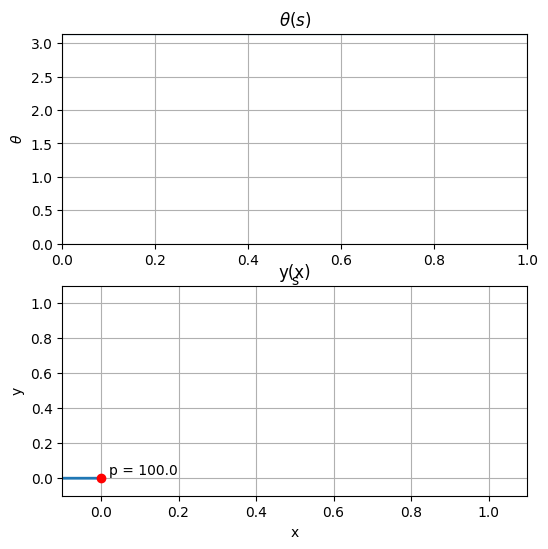

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import minimize
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Define functions
def v(theta, args):
    p = args[0]
    n = len(theta)
    v0 = np.sum((theta[1:] - theta[:-1])**2)
    v1 = np.sum(np.cos(theta))
    return 0.5 * v0 + p / (n + 1)**2 * v1

def get_xy(theta, s, x_s_a=0, y_s_a=0):
    dx_ds = np.cos(theta)
    x = cumulative_trapezoid(dx_ds, s, initial=x_s_a)

    dy_ds = np.sin(theta)
    y = cumulative_trapezoid(dy_ds, s, initial=y_s_a)

    return x, y

# Initial values
theta_init = np.linspace(0, np.pi / 2, 100)
s = np.linspace(0, 1, len(theta_init))
p_values = np.arange(0, 100.1, 10)  # fewer frames for speed in notebook

# Precompute minimizations
solutions = []
for p in p_values:
    sol = minimize(v, theta_init, args=[p])
    theta_opt = sol.x
    x, y = get_xy(theta_opt, s)
    solutions.append((theta_opt, x, y))

# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
line1, = ax1.plot([], [], lw=2)
line2, = ax2.plot([], [], lw=2)
point, = ax2.plot([], [], 'ro')
annotation = ax2.annotate("", xy=(0, 0), xytext=(0.02, 0.02))

ax1.set_xlim(s[0], s[-1])
ax1.set_ylim(0, np.pi)
ax1.set_title(r"$\theta(s)$")
ax1.set_xlabel("s")
ax1.set_ylabel(r"$\theta$")
ax1.grid()

ax2.set_xlim(-0.1, 1.1)
ax2.set_ylim(-0.1, 1.1)
ax2.set_title("y(x)")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.grid()

# Update function for animation
def update(frame):
    theta, x, y = solutions[frame]
    line1.set_data(s, theta)
    line2.set_data(x, y)
    point.set_data([0], [0])
    annotation.set_position((0.02, 0.02))
    annotation.set_text(f"p = {p_values[frame]:.1f}")
    return line1, line2, point, annotation

ani = FuncAnimation(fig, update, frames=len(solutions), blit=True, interval=50)

# Display animation in Jupyter Notebook
HTML(ani.to_jshtml())
